In [321]:
import torch
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import plotnine as gg
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
import seaborn as sns
import tree
from data import rosetta_data_loader

import sys
import argparse
import re
import logging

import pandas as pd
pd.set_option('display.max_colwidth', None)

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

torch.hub.set_dir('/data/rsg/chemistry/jyim/.cache/torch')
plt.rcParams.update({'font.size': 14})

In [322]:
all_csvs = []
results_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_rf_benchmark_2'
# results_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/continue_0/05D_01M_2023Y_21h_15m_16s/unconditional/noise_level_01_rf_benchmark_3'
print(f'Reading samples from {results_dir}')

def process_path(x):
    length_path = os.path.join(*x.split('/')[-5:])
    return os.path.join(results_dir, length_path)

for sample_length in os.listdir(results_dir):
    if '.' in sample_length:
        continue
    length_dir = os.path.join(results_dir, sample_length)
    for sample_name in os.listdir(length_dir):
        if '.' in sample_name:
            continue
        csv_path = os.path.join(length_dir, sample_name, 'mpnn', 'sc_results.csv')
        sample_id = int(sample_name.split('_')[1])
        if os.path.exists(csv_path):
            design_csv = pd.read_csv(csv_path, index_col=0)
            length = int(sample_length.split('_')[1])
            design_csv['length'] = length
            design_csv['sequence_id'] = design_csv['sample_path'].apply(lambda x: int(os.path.basename(x).replace('.pdb', '').split('_')[1]))
            design_csv['esmf_path'] = design_csv['sample_path'].apply(process_path)
            del design_csv['sample_path']
            design_csv['sample_id'] = sample_id
            design_csv['backbone_path'] = os.path.join(results_dir, f'length_{length}', f'sample_{sample_id}', 'sde_1.pdb')
            all_csvs.append(design_csv)
benchmark_df = pd.concat(all_csvs)


Reading samples from /data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_rf_benchmark_2


In [323]:
length_categories = [
    '100-200', '200-300', '300-400', '400-500'
]
buckets = np.arange(200, 501, 100)
buckets[-1] += 1

def df_process(raw_df, length_cutoff=True):
    # Process sample path
    df = raw_df.copy()
    if length_cutoff:
        df = df[df.length >= 100]
    # Separate based on whether MPNNed
    df['header'] = df['header'].fillna('')
    df = df[df['header'].map(lambda x: 'sde_1' not in x)]
    return df

def sc_filter(raw_df, metric):
    # Pick best self-consistency sample
    if metric == 'rmsd':
        df = raw_df.sort_values('rmsd', ascending=True)
    elif metric == 'tm':
        df = raw_df.sort_values('tm_score', ascending=False)
    else:
        raise ValueError(f'Unrecognized metric: {metric}')
    df = df.groupby(['length', 'sample_id']).first().reset_index()

    # Separate into different length groups
    df['length_group'] = df.length.map(lambda x: length_categories[np.sum(x > buckets).item()])
    df['length_group'] = pd.Categorical(df['length_group'], ordered=True, categories=length_categories)

    # Calculate how designable
    cutoff = 0.5
    df['designable'] = df.tm_score.map(lambda x: x > cutoff)
    designable_df = pd.pivot_table(df, values='designable', index='length_group', aggfunc=np.mean).reset_index()
    percent_designable = df['designable'].mean()
    print(f'Percent designable: {percent_designable}')
    print(f'Average scRMSD: {df.rmsd.mean()}')
    return df, designable_df


def process_pipeline(raw_df, metric, length_cutoff=True):
    processed_df = df_process(raw_df, length_cutoff=length_cutoff)
    seq_8_df = processed_df[(processed_df.sequence_id < 8)]
    
    df, designable = sc_filter(processed_df, metric=metric)
    designable['Sequences'] = 100
    df['Sequences'] = 100
    df_8, designable_8 = sc_filter(seq_8_df, metric=metric)
    df_8['Sequences'] = 8
    designable_8['Sequences'] = 8
    samples_df = pd.concat([df, df_8], axis=0)
    designable_df = pd.concat([designable, designable_8], axis=0)
    return samples_df, designable_df


# Compare with RFdiffusion

In [324]:
# Format RF diffusion samples
s2f_df = pd.read_csv('../S2F_data.csv')
s2f_df['Unconditional'] = s2f_df.problem.apply(lambda x: 'uncond' in x)
rfdiff_samples_df = s2f_df[s2f_df['Unconditional']]
metric = 'rmsd_af2_des'
df_temp = rfdiff_samples_df.sort_values(metric)
df_temp = df_temp.drop_duplicates('name')

cols = [
    'rmsd_af2_des',
    'problem',
    'random',
]
formatted_rf_diff = {
    'length': df_temp.problem.apply(lambda x: int(x.split('_')[1])),
    'rmsd': df_temp.rmsd_af2_des,
    'model': df_temp.random.map({
        'Outputs without Pre-Training': r'RFdiffusion* ($N_{seqs}=8$)' + '\nno pretraining',
        'Outputs with Pre-Training': r'RFdiffusion* ($N_{seqs}=8$)',
    }),
}
formatted_rf_diff = pd.DataFrame(formatted_rf_diff)


/tmp/ipykernel_591170/2103442794.py:2: DtypeWarning: Columns (98,118,119,121,122,127,133,134,135,139,140) have mixed types. Specify dtype option on import or set low_memory=False.


In [325]:
def process_df(raw_df, num_seqs):
    formatted_framediff = rmsd_samples[rmsd_samples.Sequences == num_seqs][['length', 'rmsd']]
    formatted_framediff = formatted_framediff[formatted_framediff.length.isin([70, 100, 200, 300])]
    formatted_framediff['model'] = r'FrameDiff ($N_{seqs}=$' + f'{num_seqs})'
    return formatted_framediff

In [326]:
# Format FrameDiff samples
rmsd_samples, _ = process_pipeline(benchmark_df, metric='rmsd', length_cutoff=False)
formatted_seq_100_df = process_df(rmsd_samples, 100)
formatted_seq_8_df = process_df(rmsd_samples, 8)
formatted_seq_100_df.length.value_counts()

Percent designable: 0.955
Average scRMSD: 2.3279888656785515
Percent designable: 0.8775
Average scRMSD: 3.504519236888246


70     100
100    100
200    100
300    100
Name: length, dtype: int64

In [327]:
formatted_df = pd.concat([formatted_rf_diff, formatted_seq_100_df, formatted_seq_8_df], axis=0)
formatted_df = formatted_df[~formatted_df.model.isna()]

In [328]:
plt.rcParams.update({'font.size': 22, "font.weight": 'bold', "axes.labelweight": 'bold'})

/tmp/ipykernel_591170/2582391991.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


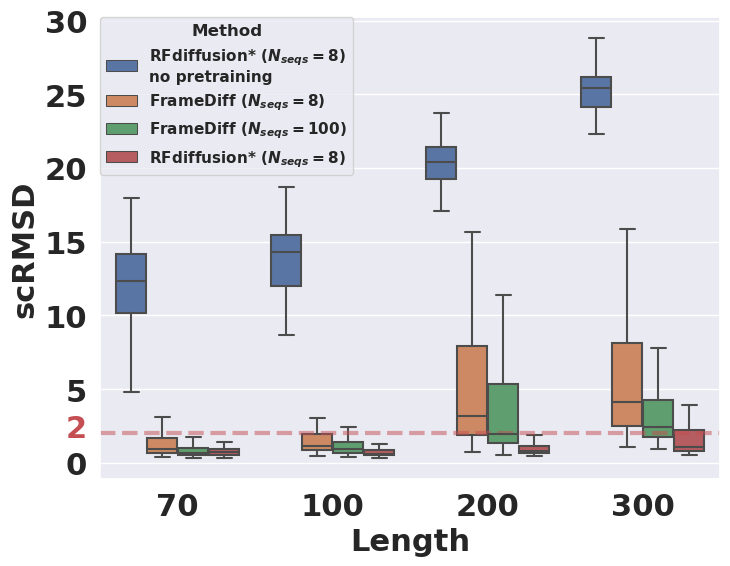

In [329]:
order = [
    r'RFdiffusion* ($N_{seqs}=8$)' + '\nno pretraining',
    r'FrameDiff ($N_{seqs}=$8)',
    r'FrameDiff ($N_{seqs}=$100)',
    r'RFdiffusion* ($N_{seqs}=8$)'
]
# order = ['FrameDiff', 'RFdiffusion*']
# order = ['RFdiffusion* \nno pretraining','FrameDiff 8 seqs', 'FrameDiff 100 seqs', 'RFdiffusion*']
ax = sns.boxplot(
    x = 'length',
    y = 'rmsd',
    data = formatted_df,
    hue = 'model',
    hue_order=order,
    showfliers = False
)
ax.set_yticklabels(ax.get_yticks().astype(int), size = 22)
ax.set_xticklabels([70, 100, 200, 300], size = 22)

# plt.ylim(0.0, 1.1)
# plt.show()
plt.xlabel('Length', fontsize=22)
plt.ylabel('scRMSD', fontsize=22)
legend = plt.legend(bbox_to_anchor=(0., 1.0), loc='upper left', borderaxespad=0, fontsize=11)
ax.legend_.set_title('Method')
plt.axhline(y = 2.0, color = 'r', linestyle = '--', linewidth=3, alpha=0.5)
plt.text(x=-0.725, y=1.75, s='2', color='r', size=22)
# plt.show()
plt.savefig('rfdiffusion_benchmark.png', bbox_inches='tight')

/tmp/ipykernel_591170/4065393493.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


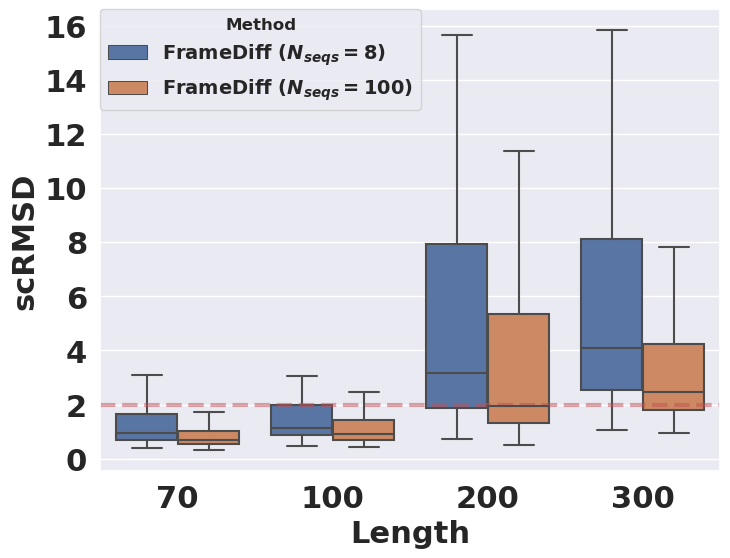

In [330]:
order = [
    # r'RFdiffusion* ($N_{seqs}=8$)' + '\nno pretraining',
    r'FrameDiff ($N_{seqs}=$8)',
    r'FrameDiff ($N_{seqs}=$100)',
    # r'RFdiffusion* ($N_{seqs}=8$)'
]
# order = ['FrameDiff', 'RFdiffusion*']
# order = ['RFdiffusion* \nno pretraining','FrameDiff 8 seqs', 'FrameDiff 100 seqs', 'RFdiffusion*']
ax = sns.boxplot(
    x = 'length',
    y = 'rmsd',
    data = formatted_df,
    hue = 'model',
    hue_order=order,
    showfliers = False
)
ax.set_yticklabels(ax.get_yticks().astype(int), size = 22)
ax.set_xticklabels([70, 100, 200, 300], size = 22)

# plt.ylim(0.0, 1.1)
# plt.show()
plt.xlabel('Length', fontsize=22)
plt.ylabel('scRMSD', fontsize=22)
legend = plt.legend(bbox_to_anchor=(0., 1.0), loc='upper left', borderaxespad=0, fontsize=14)
ax.legend_.set_title('Method')
plt.axhline(y = 2.0, color = 'r', linestyle = '--', linewidth=3, alpha=0.5)
# plt.text(x=-0.725, y=1.71, s='2', color='r', size=22)
# plt.show()
plt.savefig('rfdiffusion_benchmark_anonymous.png', bbox_inches='tight')

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/seaborn/categorical.py:373: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


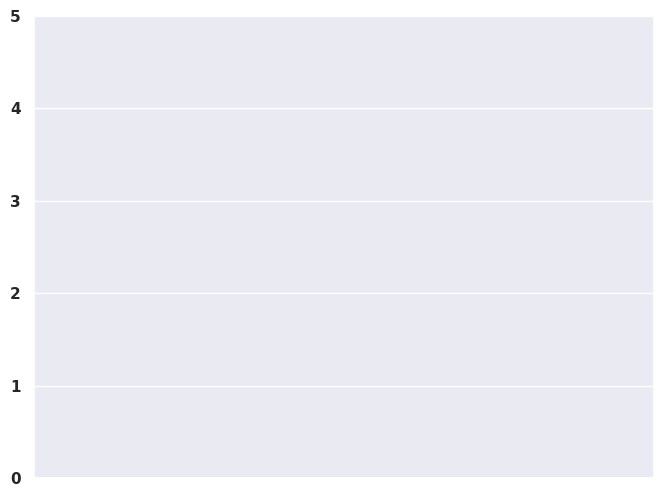

In [312]:
zoomed_df = formatted_df[formatted_df.model.isin(['FrameDiff', 'RFdiffusion*'])]
order = ['FrameDiff', 'RFdiffusion*']
ax = sns.boxplot(
    x = 'length',
    y = 'rmsd',
    data = zoomed_df,
    hue = 'model',
    hue_order=order,
    showfliers = False,
    palette = ['#ff7f0e', '#2ca02c']
)
ax.set(xlabel=None)
ax.set(ylabel=None)
plt.ylim(0.0, 5)
legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
legend.remove()
plt.show()
# plt.savefig('rfdiffusion_benchmark.png')
